## Epic 4 - Clustering

To find clusters, we will be using the $K$-means clustering method. This method tries to find $K$ clusters in such a way that the sum of the squared distances between the objects and their assigned cluster mean is minimized. Choosing a right value for $K$ is crucial since this will make it able to  identify meaningful patterns in the data.

To determine $K$, we will first use the Elbow method. In addition to this, we will use the Silhouette score as an extra verification step for the elbow method.


In [19]:
# Importing necessary libraries

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import silhouette_score

from dotenv import load_dotenv
import os
from sqlalchemy import create_engine

In [20]:
## Database connection 
load_dotenv()

SERVER = os.environ.get('SERVER')
DATABASE = os.environ.get('DATAWAREHOUSE')
UID = os.environ.get('USER') 
PWD = os.environ.get('PASSWORD')

connection_string = f'mssql+pyodbc://{UID}:{PWD}@{SERVER}/{DATABASE}?driver=ODBC+Driver+17+for+SQL+Server'
engine = create_engine(connection_string)

In [21]:
## Retrieving data 
conn = engine.connect()

contacts = pd.read_sql_table('DimContact', conn)
accounts = pd.read_sql_table('DimCustomer', conn)

conn.close()

In [22]:
## Data manipulation
contacts = contacts.merge(accounts, how='left', left_on='Account_ID', right_on='Customer_ID')
contacts = contacts.sort_values(['Contact_ID', 'Contact_status'])    
contacts = contacts.drop_duplicates('Contact_ID', keep='first')

In [23]:
## Data encoding
encoded_features = ['Account_encoded', 'Titel_encoded', 'Voka_employee_encoded', 'Regio_encoded', 'Subregio_encoded', 'Company_kind_encoded', 'Company_type_encoded', 'Primary_activity_encoded']
    
account_encoder = LabelEncoder()
title_encoder = LabelEncoder()
voka_encoder = LabelEncoder()
regio_encoder = LabelEncoder()
subregio_encoder = LabelEncoder()
company_kind_encoder = LabelEncoder()
company_type_encoder = LabelEncoder()
primary_activity_encoder = LabelEncoder()

contacts['Account_encoded'] = account_encoder.fit_transform(contacts['Account_ID'])
contacts['Titel_encoded'] = title_encoder.fit_transform(contacts['Functie_title'])
contacts['Voka_employee_encoded'] = voka_encoder.fit_transform(contacts['Voka_medewerker'])
contacts['Regio_encoded'] = regio_encoder.fit_transform(contacts['Geografische_regio'])
contacts['Subregio_encoded'] = subregio_encoder.fit_transform(contacts['Geografische_subregio'])
contacts['Company_kind_encoded'] = company_kind_encoder.fit_transform(contacts['Ondernemingsaard'])
contacts['Company_type_encoded'] = company_type_encoder.fit_transform(contacts['Ondernemingstype'])
contacts['Primary_activity_encoded'] = primary_activity_encoder.fit_transform(contacts['Primaire_activiteit'])

# Standardize data
scaler = StandardScaler()
contacts_scaled = scaler.fit_transform(contacts[encoded_features])

### Elbow method

A good cluster is one in which the points are close to the cluster mean. The total distance from the points to the cluster mean is called the *intra-cluster variation* (or within-cluster sum of square), and this value should be minimized. In the elbow method, we will, for different values of $K$, take the sum of the intra-cluster variation (inertia) and plot it on a graph. The optimal value for $K$ is the one for which the inertia suddenly falls (it forms an elbow) 

c:\Users\School\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\School\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\School\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\School\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\School\anaconda3\lib\site-packages\sklearn\

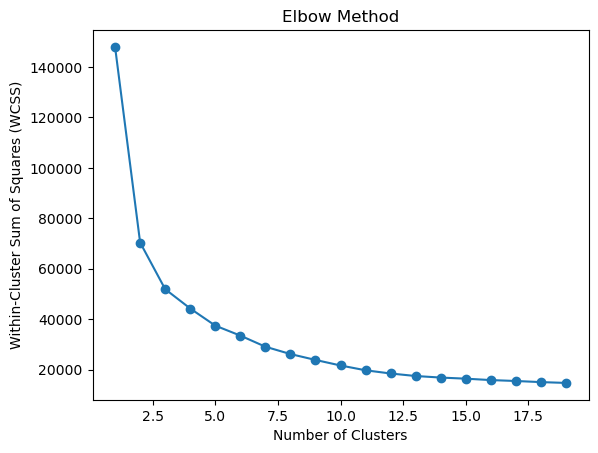

In [24]:
## Elbow method

wcss = []  # Within-cluster sum of squares

# Try different numbers of clusters (adjust the range based on your data)
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(contacts_scaled)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 20), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.show()

### Conclusion

From the graph above, it is not very clear where the elbow is. Therefore, we will use an additional method which will help us determine the optimal value for $K$

### Silhouette score

The silhouette score is a measure of how similar an object is to its own cluster compared to other clusters. The silhouette score has a range of $[-1, 1]$ and is interpreted as follows:

- $-1$ &rarr; the worst scenario; the points are misplaced
- $0$ &rarr; the clusters overlap
- $1$ &rarr; the best scenario; the points are very compact within their clusters and far from other clusters. 

Thus how closer we are to $1$, how better

In [25]:
for num_clusters in range(2, 20):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(contacts_scaled)
    silhouette_avg = silhouette_score(contacts_scaled, cluster_labels)
    
    print(f"Number of clusters: {num_clusters}, Silhouette Score: {silhouette_avg}")

c:\Users\School\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters: 2, Silhouette Score: 0.5201002555039201


c:\Users\School\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters: 3, Silhouette Score: 0.5354561614266923


c:\Users\School\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters: 4, Silhouette Score: 0.3834491118168233


c:\Users\School\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters: 5, Silhouette Score: 0.29119349230942154


c:\Users\School\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters: 6, Silhouette Score: 0.2720605495058265


c:\Users\School\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters: 7, Silhouette Score: 0.2947071818087027


c:\Users\School\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters: 8, Silhouette Score: 0.3006714102888204


c:\Users\School\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters: 9, Silhouette Score: 0.3075895828346626


c:\Users\School\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters: 10, Silhouette Score: 0.3082212324293076


c:\Users\School\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters: 11, Silhouette Score: 0.31688316775924985


c:\Users\School\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters: 12, Silhouette Score: 0.3151791679511244


c:\Users\School\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters: 13, Silhouette Score: 0.3122689714246029


c:\Users\School\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters: 14, Silhouette Score: 0.2973597012284407


c:\Users\School\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters: 15, Silhouette Score: 0.29771977799237614


c:\Users\School\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters: 16, Silhouette Score: 0.30052524132843306


c:\Users\School\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters: 17, Silhouette Score: 0.29191724250065143


c:\Users\School\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters: 18, Silhouette Score: 0.28663543256493573


c:\Users\School\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters: 19, Silhouette Score: 0.28009284192105116


### Conclusion

As can been seen from the above outputs, the optimal value for $K$ seems to be 3.